In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i].round(4)}) for label {i}')
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

In [3]:
opt_features = ['AccumCharge', 'R_cht', 'z_cc', 'pe_std',
               'nPMTs',] #'ht_kurtosis', 'ht_25-20p', 'R_cc',
               #'ht_5-2p', 'pe_mean', 'jacob_cht', 'phi_cc',
               #'ht_35-30p', 'ht_20-15p', 'pe_35p', 'ht_30-25p']

In [4]:
path='/mnt/cephfs/ml_data/mc_2021/'
data = pd.read_csv(f'{path}processed_data/ProcessedTrainReal/ProcessedTrain.csv.gz')
data = data[data['edepR'] < 17.2]

In [5]:
def noised(X, ε_mean, ε_std):
    μ = ε_mean * np.mean(X.to_numpy(), axis=0)*np.random.uniform(size=[X.shape[1],])
    σ = ε_std * np.std(X.to_numpy(), axis=0)*np.random.uniform(size=[X.shape[1],])
    noise = np.random.normal(μ, σ, size=(X.shape[0], X.shape[1]))
    return X + noise

In [6]:
from sklearn.utils import shuffle

data = shuffle(data)

In [7]:
import numpy

original = data[opt_features][400000:]
target = noised(original[:400000], 0.05, 0.25)

original_weights = numpy.ones(len(original))

In [8]:
columns = original.columns

In [9]:
import numpy 
from matplotlib import pyplot as plt
from hep_ml.metrics_utils import ks_2samp_weighted
hist_settings = {'bins': 100, 'density': True, 'alpha': 0.7}

def draw_distributions(original, target, new_original_weights):
    plt.figure(figsize=[15, 15])
    for id, column in enumerate(columns, 1):
        xlim = numpy.percentile(numpy.hstack([target[column]]), [0.01, 99.99])
        plt.subplot(4, 4, id)
        plt.hist(original[column], weights=new_original_weights, range=xlim, **hist_settings)
        plt.hist(target[column], range=xlim, **hist_settings)
        plt.title(column)
        print('KS over ', column, ' = ', ks_2samp_weighted(original[column], target[column], 
                                         weights1=new_original_weights, weights2=numpy.ones(len(target), dtype=float)))

KS over  AccumCharge  =  0.03329945220538677
KS over  R_cht  =  0.06193224756854099
KS over  z_cc  =  0.0056160922537674685
KS over  pe_std  =  0.030901499465245702
KS over  nPMTs  =  0.021285737941470928


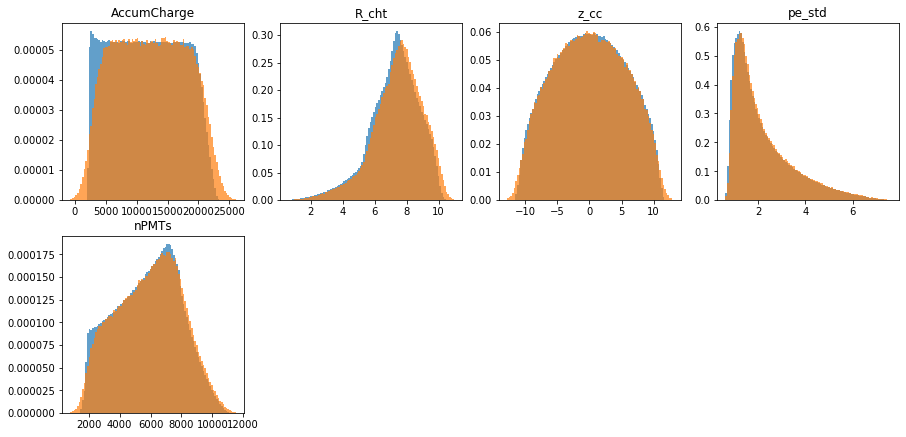

In [10]:
draw_distributions(original, target, original_weights)

In [11]:
from sklearn.model_selection import train_test_split

original_train, original_test = train_test_split(original, test_size=0.2)
target_train, target_test = train_test_split(target, test_size=0.2)

original_weights_train = numpy.ones(len(original_train))
original_weights_test = numpy.ones(len(original_test))

In [12]:
original_train.shape, original_test.shape, target_train.shape, target_test.shape 

((3363550, 5), (840888, 5), (320000, 5), (80000, 5))

In [13]:
from hep_ml import reweight

KS over  AccumCharge  =  0.013154339674080973
KS over  R_cht  =  0.018437431684314887
KS over  z_cc  =  0.015708688449105335
KS over  pe_std  =  0.015897524397751606
KS over  nPMTs  =  0.011647822619189285
CPU times: user 57min 5s, sys: 3.41 s, total: 57min 9s
Wall time: 57min 37s


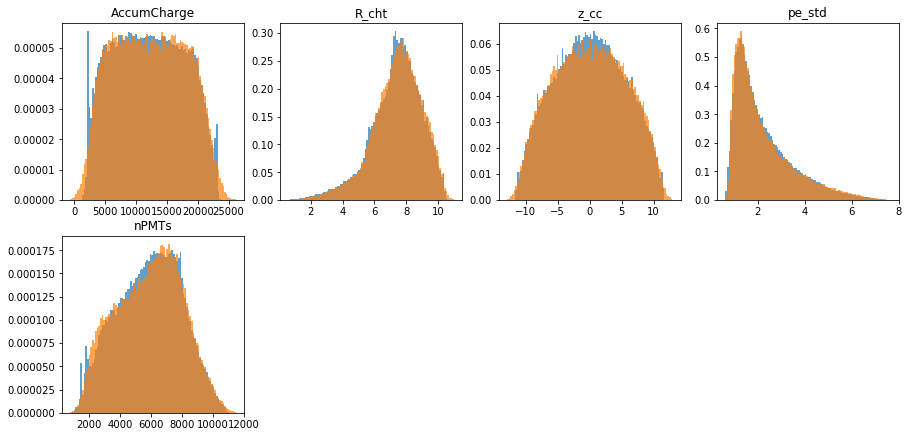

In [14]:
%%time

reweighter = reweight.GBReweighter(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    min_samples_leaf=5000,
)
reweighter.fit(
    original_train, target_train,
)

gb_weights_test = reweighter.predict_weights(original_test)
draw_distributions(original_test, target_test, gb_weights_test)

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

data_conc = numpy.concatenate([original_test, target_test])
labels = numpy.array([0] * len(original_test) + [1] * len(target_test))

weights = {}
weights['original'] = original_weights_test
weights['gb_weights'] = gb_weights_test

for name, new_weights in weights.items():
    W = numpy.concatenate([new_weights / new_weights.sum() * len(target_test), [1] * len(target_test)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data_conc, labels, W, random_state=42, train_size=0.51)
    clf = GradientBoostingClassifier(subsample=0.3, n_estimators=50).fit(Xtr, Ytr, sample_weight=Wtr)
    
    print(name, roc_auc_score(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts))

original 0.6823988721780838
gb_weights 0.6723716946647508


In [16]:
# original 0.7615415063874171
# gb_weights 0.7718626785125609
